# 00 – Problem Setup and Exploratory Analysis

## Context and Motivation

Prior research comparing econometric and neural models for volatility forecasting has produced **mixed and unstable results** (Sahiner et al., 2023; Kilic, 2025). Rather than asking "which model is best," this project investigates **when and why different model classes succeed or fail** across market regimes. This behavioral, regime-conditional approach moves beyond headline accuracy metrics to understand how GARCH, LSTM, and Transformer models respond differently to calm versus turbulent periods.

This notebook establishes the empirical foundation: we define the modeling target (daily conditional variance), justify the evaluation proxy (squared daily returns), and document stylized facts that motivate regime-aware analysis.

---

> **Data acquisition note**  
> This notebook assumes daily S&P 500 price data stored locally.  
> A guarded download cell is provided below and should be run only once.

In [127]:
import sys
from pathlib import Path

# Add project root to PYTHONPATH
PROJECT_ROOT = Path("..").resolve()
sys.path.insert(0, str(PROJECT_ROOT))

print("Project root added:", PROJECT_ROOT)

Project root added: D:\Projects\regime-aware-volatility-forecasting


In [ ]:
from src.data.fetch_data import download_sp500

RAW_DIR = Path("../data/raw")
PRICES_CSV = RAW_DIR / "prices.csv"

DOWNLOAD_DATA = False  # set to True only for first run or refresh

if DOWNLOAD_DATA or not PRICES_CSV.exists():
    download_sp500(out_path=PRICES_CSV)


## Notebook Scope

This notebook accomplishes three objectives:

1. **Define the modeling target**: Daily conditional variance as a theoretical construct versus its empirical proxy
2. **Establish evaluation methodology**: Why squared daily returns serve as the comparison benchmark despite inherent noise
3. **Document empirical patterns**: Confirm volatility clustering, heavy tails, and regime-like alternations that motivate the comparative framework

**What comes later:**
- Regime definitions and validation (Notebook 01)
- Model specifications and forecasting (Notebooks 02-05)
- Regime-conditional diagnostics (Notebook 06)

## Definitions and Notation

Let price at time $t$ be $P_t$. Then log return is defined as:

$$
r_t = \log(P_t) - \log(P_{t-1})
$$

The modeling target is **daily conditional variance**:

$$
\sigma_t^2 = \mathrm{Var}(r_t \mid \mathcal{F}_{t-1}) = \mathbb{E}[r_t^2 \mid \mathcal{F}_{t-1}]
$$

where $\mathcal{F}_{t-1}$ represents all the information available up to time $t-1$. This assumes $\mathbb{E}[r_t \mid \mathcal{F}_{t-1}] = 0$, which is standard for daily returns at this frequency.

**Why variance, not volatility?** Variance is the canonical target in GARCH-style models and allows direct comparison between econometric and neural approaches. Volatility (the square root of variance) can be derived if needed, but variance is the natural scale for this analysis.

## Why Variance is Unobservable

Daily conditional variance $\sigma_t^2$ is a **conditional expectation**, not a directly observable quantity. It represents the expected squared return given past information, which is a theoretical construct rather than a measurable outcome.

Since $\sigma_t^2$ cannot be observed, we must evaluate forecasts against an empirical proxy constructed from realized returns. This introduces unavoidable noise into the evaluation process, and model performance will be inherently limited by the quality of the proxy, not just by modeling choices.

**Practical implication:** Even a perfect model of $\sigma_t^2$ will appear imperfect when evaluated against a noisy realization. This is why low explanatory power $(R^2 \approx 0.05-0.15)$ is typical and does not indicate modeling failure.

## Realized Proxy: Squared Daily Returns

We use **squared daily returns ($r_t^2$)** as the evaluation benchmark.

**Why this works:** Under the assumption that $\mathbb{E}[r_t \mid \mathcal{F}_{t-1}] = 0$, squared returns are an **unbiased estimator** of conditional variance:

$$
\mathbb{E}[r_t^2 \mid \mathcal{F}_{t-1}] = \sigma_t^2
$$

However, $r_t^2$ is an **extremely noisy** single-observation estimator. The realized squared return can be decomposed as:

$$
r_t^2 = \sigma_t^2 + \epsilon_t
$$

where $\epsilon_t$ represents idiosyncratic noise that can be orders of magnitude larger than the signal $\sigma_t^2$. This is why intraday measures like realized volatility (computed from high-frequency data) are more stable, since they average out noise within the day.

**Evaluation philosophy:** $r_t^2$ is not treated as ground truth. Instead, it serves as a **consistent benchmark** for comparing how different model classes respond to the same noisy signal. Models are evaluated on their behavior patterns across regimes, not just aggregate accuracy.

## Why Daily Variance Forecasting is Structurally Difficult

Even an excellent model of $\sigma_t^2$ will produce forecasts that appear smooth relative to the jagged realized series $r_t^2$. This mismatch has two sources:

1. **Signal extraction problem:** The forecast $\hat{\sigma}_t^2$ targets the conditional expectation, which evolves gradually. The realization $r_t^2 = \sigma_t^2 + \epsilon_t$ contains large idiosyncratic shocks that no model should predict.

2. **Asymmetric noise:** The noise term $\epsilon_t$ in $r_t^2$ is not symmetric—extreme positive spikes (large losses or gains) dominate the distribution. Forecasts optimized under MSE will systematically underpredict these tail events.

**Key insight for regime analysis:** Different model classes respond differently to this asymmetry. GARCH's mean-reverting structure may overpredict in calm periods while lagging in turbulent ones. Neural models trained on MSE may underpredict spikes consistently. These behavioral differences are the focus of Notebook 06.

---

## Empirical Analysis

Having established the theoretical framework, we now examine **S&P 500 data from 2000-2025** to verify the empirical patterns that justify regime-conditional modeling.

This 25-year period captures multiple market regimes:
- Dot-com crash (2000-2002)
- Financial crisis (2008-2009)
- COVID-19 crash (2020)
- Recent volatility (2022-2023)

We proceed in four steps:
1. **Data loading and preprocessing** — Compute returns and check for quality issues
2. **Distribution diagnostics** — Confirm heavy tails that challenge neural optimization
3. **Volatility clustering** — Verify persistence that favors GARCH's autoregressive structure
4. **Regime intuition** — Visualize calm/turbulent alternations (formal labels in Notebook 01)

In [129]:
# =============================================================================
# IMPORTS AND CONFIGURATION
# =============================================================================

# Standard library
import sys
from pathlib import Path

# Third-party
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
import yaml

# Project modules
from src.utils.seed import set_global_seed
from src.utils.logging import get_logger
from src.utils.plotting import set_mpl_defaults, savefig
from src.data.load_data import load_prices_csv, PriceDataSchema
from src.data.preprocess import (
    compute_log_returns,
    count_missing,
    check_date_continuity,
    ReturnConfig,
)

# Configuration
set_global_seed(42)
set_mpl_defaults()
logger = get_logger()

# Load project configuration
cfg_path = Path("../src/config/data_config.yaml")
with open(cfg_path, "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

PRICES_CSV = Path(cfg["prices_csv"])
FIG_DIR = Path(cfg["figures_dir"])

schema = PriceDataSchema(
    date_col=cfg["schema"]["date_col"],
    price_col=cfg["schema"]["price_col"],
)

EXPECTED_FREQ = cfg.get("expected_frequency", None)
logger.info(f"Using prices file: {PRICES_CSV}")
logger.info(f"Saving figures to: {FIG_DIR}")

[INFO] Using prices file: ..\data\raw\prices.csv
[INFO] Saving figures to: ..\results\figures\eda


## Data Loading and Preprocessing

We load daily S&P 500 **adjusted close prices**, compute log returns $r_t$, and construct squared returns $r_t^2$. All data quality checks are explicit to prevent silent failures:

- **Monotonic dates:** Ensure no out-of-order records
- **Missing values:** Identify gaps (holidays, market closures)
- **Return sanity:** Flag any returns exceeding reasonable bounds (e.g., | $r_t$ | > 0.2)

The preprocessing pipeline is deterministic and fully reproducible via configuration files.

In [130]:
prices = load_prices_csv(PRICES_CSV, schema=schema)

logger.info(f"Date range: {prices.index.min()} to {prices.index.max()}")
logger.info(f"Number of rows: {len(prices):,}")
logger.info(f"Missing values (top):\n{count_missing(prices).head(10)}")

cont = check_date_continuity(prices, freq=EXPECTED_FREQ if EXPECTED_FREQ not in (None, "null") else None)
logger.info(f"Date continuity summary: {cont}")
prices.head()


[INFO] Date range: 2000-01-03 00:00:00 to 2025-12-16 00:00:00
[INFO] Number of rows: 6,529
[INFO] Missing values (top):
price    0
dtype: int64
[INFO] Date continuity summary: {'start': Timestamp('2000-01-03 00:00:00'), 'end': Timestamp('2025-12-16 00:00:00'), 'n_rows': 6529, 'is_monotonic': True, 'expected_n': 6772, 'missing_n': 243, 'missing_head': [Timestamp('2000-01-17 00:00:00'), Timestamp('2000-02-21 00:00:00'), Timestamp('2000-04-21 00:00:00'), Timestamp('2000-05-29 00:00:00'), Timestamp('2000-07-04 00:00:00'), Timestamp('2000-09-04 00:00:00'), Timestamp('2000-11-23 00:00:00'), Timestamp('2000-12-25 00:00:00'), Timestamp('2001-01-01 00:00:00'), Timestamp('2001-01-15 00:00:00')]}


,price
date,
2000-01-03,1455.219971
2000-01-04,1399.420044
2000-01-05,1402.109985
2000-01-06,1403.449951
2000-01-07,1441.469971


In [131]:
cfg_ret = ReturnConfig(price_col="price", eps=1e-12)
data = compute_log_returns(prices, cfg=cfg_ret)

# Drop first row with NaN return due to differencing
data = data.dropna(subset=[cfg_ret.return_col])

logger.info(f"After return computation: {len(data):,} rows")
data[[cfg_ret.return_col, cfg_ret.squared_return_col]].describe(percentiles=[0.5, 0.9, 0.95, 0.99]).T


[INFO] After return computation: 6,528 rows


,count,mean,std,min,50%,90%,95%,99%,max
log_return,6528.0,0.000236,0.012222,-0.127652,0.000639,0.012229,0.016975,0.032996,0.109572
r2,6528.0,0.000149,0.000530,0.000000,0.000030,0.000321,0.000584,0.001845,0.016295


## Return Distribution Diagnostics

The summary statistics confirm extreme distributional properties:

**Returns ($r_t$):**
- Nearly zero mean (0.024% daily ≈ 6% annualized)
- High volatility: σ = 1.22% (≈ 19% annualized)
- Extreme range: minimum -12.8%, maximum +11.0%
- Tail asymmetry: 99th percentile (+3.3%) is smaller in magnitude than 1st percentile (-12.8%)

**Squared returns ($r_t^2$):**
- Mean: 0.000149, Median: 0.000030 (**5× difference** indicates severe right skew)
- 99th percentile is **12× the mean** (heavy tail)
- Maximum (1.63%) corresponds to 12-13% daily price moves

We visualize these patterns below to understand their implications for model design.

## Visual Distribution Analysis

We visualize the return distribution using two complementary approaches:

1. **Histogram with normal overlay**: Shows the empirical density versus a fitted normal distribution to highlight deviation from Gaussianity

2. **QQ-plot**: Quantile-quantile plot comparing sample quantiles against theoretical normal quantiles. Deviations from the diagonal would indicate non-normality

In [132]:
# Prepare returns data
returns = data[cfg_ret.return_col].dropna()
# Prepare squared returns data
squared_returns = data[cfg_ret.squared_return_col].dropna()

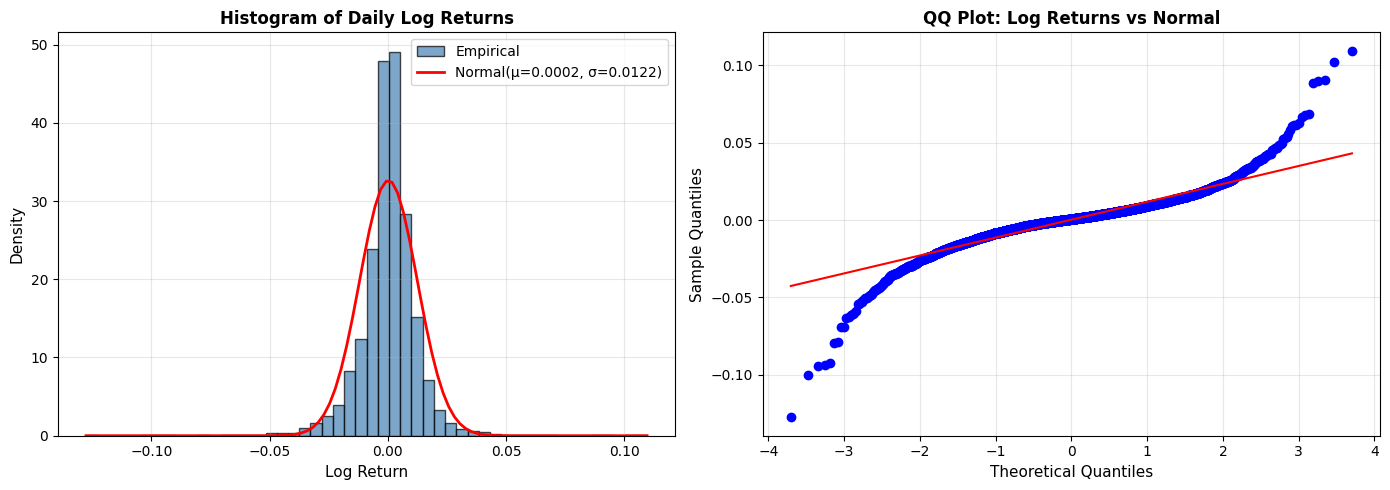

In [133]:
# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot histogram
ax = axes[0]

n, bins, patches = ax.hist(returns, bins=50, density=True, alpha=0.7, 
                           color='steelblue', edgecolor='black', label='Empirical')

# Fit normal distribution
mu, std = returns.mean(), returns.std()
x = np.linspace(returns.min(), returns.max(), 100)
normal_density = stats.norm.pdf(x, mu, std)
ax.plot(x, normal_density, 'r-', linewidth=2, label=f'Normal(μ={mu:.4f}, σ={std:.4f})')

ax.set_xlabel('Log Return', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('Histogram of Daily Log Returns', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Generate QQ plot
ax = axes[1]

stats.probplot(returns, dist="norm", plot=ax)

ax.set_xlabel('Theoretical Quantiles', fontsize=11)
ax.set_ylabel('Sample Quantiles', fontsize=11)
ax.set_title('QQ Plot: Log Returns vs Normal', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()
savefig(fig, FIG_DIR / "return_distribution_diagnostics.png")

### Interpretation

**Histogram with Normal Overlay:**
- **Leptokurtic shape**: Center peak exceeds the normal curve, which implies that most days have near-zero returns
- **Fat tails**: Both tails extend beyond normal predictions, with empirical mass at ±10% where normal density ≈ 0
- **Asymmetry**: Left tail reaches -13% (crash days); right tail reaches +11% (rally days)

**QQ-Plot:**
- **Center** (-2σ to +2σ): Points follow diagonal closely, indicating near-normal behavior for moderate daily moves
- **Left tail**: Points fall below diagonal starting at -2σ show that crashes are more extreme than normal predicts
- **Right tail**: Points rise above diagonal, confirming that large gains also exceed normal, though less severely than crashes

**Implications:**
1. **Fat tails validate heteroskedastic modeling**: GARCH's conditional variance framework is justified
2. **Leptokurtosis challenges MSE optimization**: Neural models will struggle without robust transformations
3. **Tail asymmetry motivates regime-conditional evaluation**: Model performance likely differs between calm (center) and turbulent (tail) periods

## Squared Return Distribution

Squared returns $r_t^2$ are the evaluation benchmark for variance forecasts. Their distribution is far more extreme than returns themselves.

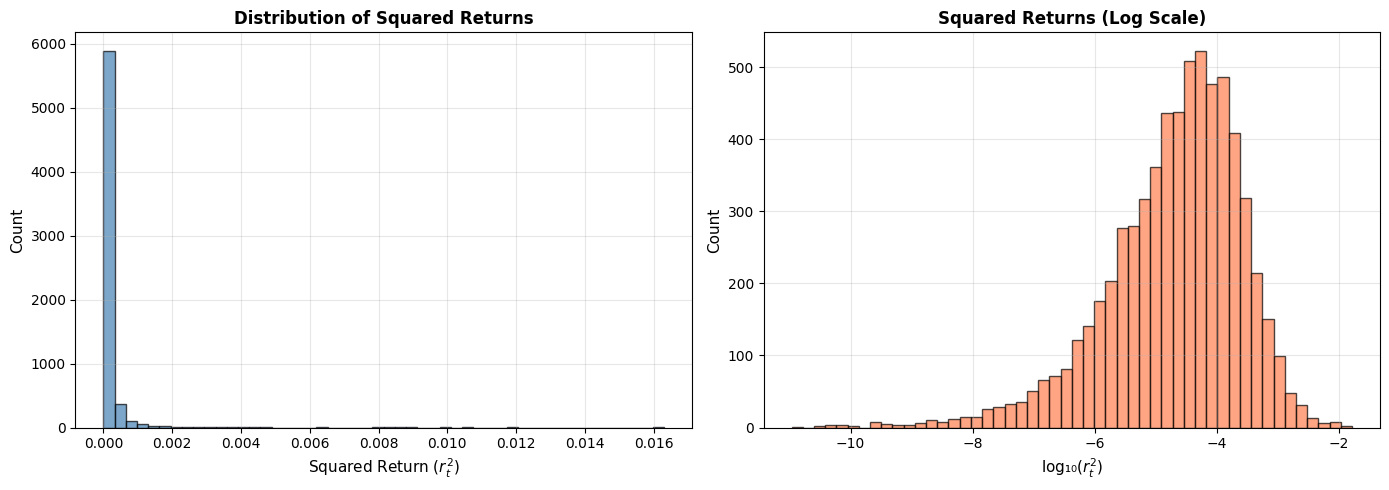

In [134]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LEFT: Histogram with extreme right skew
ax = axes[0]
ax.hist(squared_returns, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax.set_xlabel('Squared Return ($r_t^2$)', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Distribution of Squared Returns', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

# RIGHT: Log-scale histogram to show full range
ax = axes[1]
# Filter out zeros for log scale
squared_nonzero = squared_returns[squared_returns > 0]
ax.hist(np.log10(squared_nonzero), bins=50, color='coral', edgecolor='black', alpha=0.7)
ax.set_xlabel('log₁₀($r_t^2$)', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Squared Returns (Log Scale)', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()
savefig(fig, FIG_DIR / "squared_return_distribution.png")

### Interpretation

**What makes squared returns different from returns:**

**Extreme concentration:**
- Linear scale (left): Distribution appears as a spike at zero with a thin right tail
- Log scale (right): Reveals 4 orders of magnitude range, where most days are at 0.003% and tail events are at 1.6%

**Practical consequences:**
1. **Signal extraction is sparse**: The variance signal $\sigma_t^2$ must be inferred from observations that are 99% noise
2. **Optimization instability**: Gradients in neural training will be dominated by rare spike days unless transformations are applied
3. **GARCH structural advantage**: The $\alpha \epsilon_{t-1}^2$ shock term explicitly amplifies extremes, aligning with this distribution
4. **Forecasting limits**: Even perfect models of $\sigma_t^2$ achieve only $R^2 \approx 0.05$-$0.15$ when evaluated against noisy $r_t^2$

## Volatility Clustering: The Core Stylized Fact

Volatility clustering is the empirical observation that **large moves tend to follow large moves, and small moves follow small moves**. This manifests as:

1. **Weak return autocorrelation:** Returns $r_t$ show minimal serial correlation (market efficiency)
2. **Strong squared return autocorrelation:** Squared returns $r_t^2$ exhibit significant persistence over 10-20 lags

**Why this pattern matters:**
- It justifies **autoregressive variance models** (GARCH, EGARCH) that explicitly model $\sigma_t^2$ as a function of past $\sigma_{t-1}^2$ and $\epsilon_{t-1}^2$
- It suggests **LSTM/Transformer models** should, in principle, capture this temporal dependence through their memory mechanisms
- It motivates regime-conditional analysis. Persistence may differ between calm (slow decay) and turbulent (rapid shocks) periods

We verify this using time series plots and autocorrelation functions.

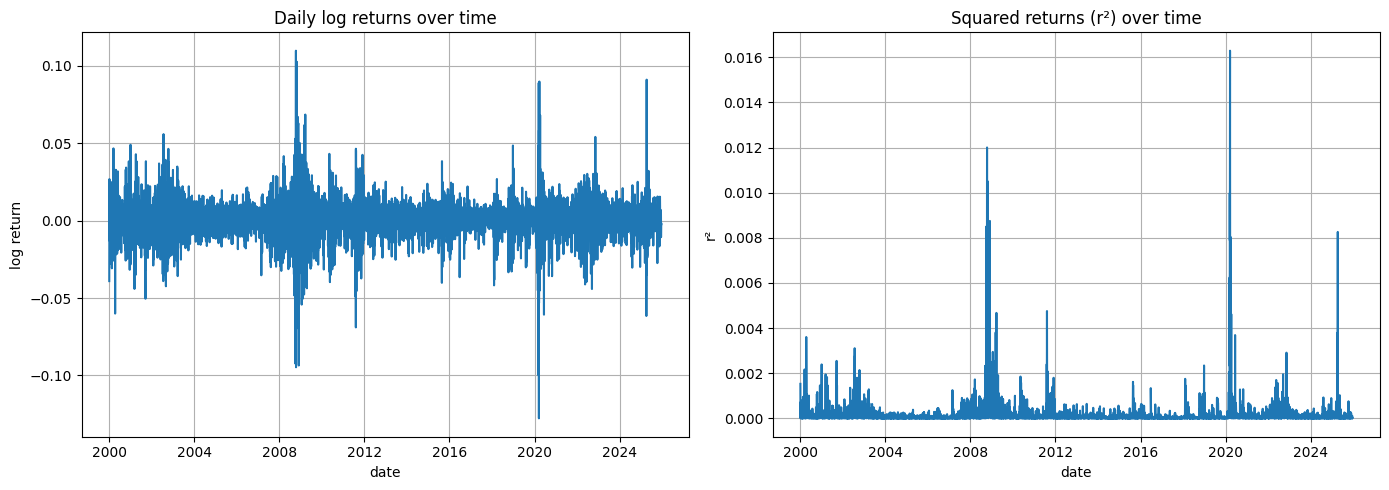

In [135]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time series of daily log returns
ax = axes[0]
ax.plot(data.index, returns.values)
ax.set_title("Daily log returns over time")
ax.set_xlabel("date")
ax.set_ylabel("log return")

# Time series of squared returns
ax = axes[1]
ax.plot(data.index, squared_returns.values)
ax.set_title("Squared returns (r²) over time")
ax.set_xlabel("date")
ax.set_ylabel("r²")

plt.tight_layout()
plt.show()
savefig(fig, FIG_DIR / "ts_returns_and_squared.png")


### Quantifying Persistence

The time series above show clustering visually. We now quantify this persistence using the autocorrelation function (ACF) of squared returns, which measures correlation between $r_t^2$ and $r_{t-k}^2$ at various lags $k$.

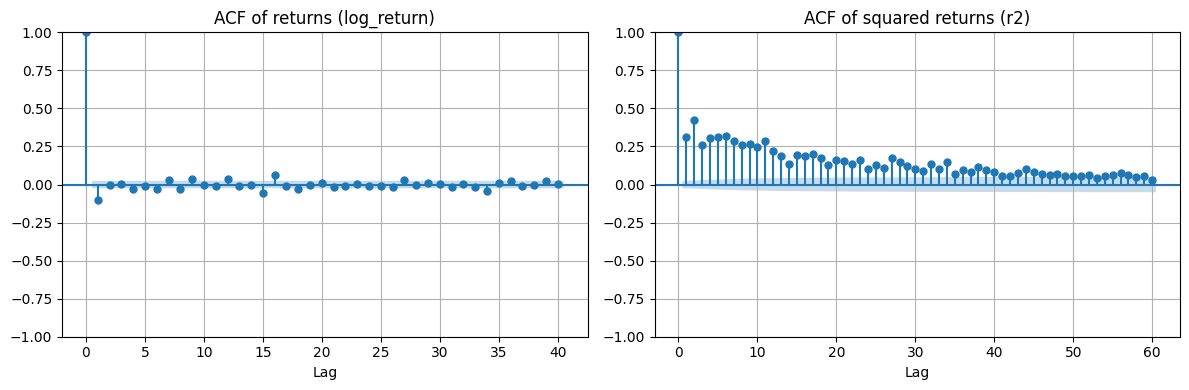

In [136]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# ACF of returns
plot_acf(data[cfg_ret.return_col].dropna(), lags=40, ax=axes[0]) # 40 lags is enough because no autocorrelation is expected other than noise
axes[0].set_title(f"ACF of returns ({cfg_ret.return_col})")
axes[0].set_xlabel("Lag")

# ACF of squared returns  
plot_acf(data[cfg_ret.squared_return_col].dropna(), lags=60, ax=axes[1]) # 60 lags to capture full delay of volatility clustering
axes[1].set_title(f"ACF of squared returns ({cfg_ret.squared_return_col})")
axes[1].set_xlabel("Lag")

plt.tight_layout()
plt.show()
savefig(fig, FIG_DIR / "acf_returns_and_squared.png")

### Interpretation

**Time series patterns:**
- **Returns ($r_t$)**: Oscillate randomly around zero with occasional large spikes (2008 financial crisis, 2020 COVID crash). No apparent serial dependence implying that large moves don't predict subsequent large moves.
- **Squared returns ($r_t^2$)**: Show clear **clustering** - spikes are followed by periods of sustained elevated volatility (e.g., 2008-2009, 2020-2021), while calm periods remain calm for extended stretches.

**Autocorrelation confirms clustering:**
- **Returns ACF** (left): Near-zero autocorrelation at all lags, consistent with market efficiency
- **Squared returns ACF** (right): Strong positive autocorrelation at lags 1-20, decaying slowly
  - At lag 1: ≈0.30 correlation (today's variance predicts tomorrow's)
  - Persistence extends 20+ days, indicating long memory in volatility dynamics

**Model implications:**
- GARCH's autoregressive structure ($\beta \sigma_{t-1}^2 + \alpha \epsilon_{t-1}^2$) is **structurally aligned** with this persistence
- LSTM/Transformer models must **learn** this pattern from data; no built-in mean-reversion
- The clustering suggests regime-dependent forecasting: persistence may be stronger during turbulent periods (tested in Notebook 06)

## Preliminary Visual Intuition for Regime Dynamics

We do not define formal regime labels in this notebook. That is deferred to Notebook 01, where we ensure **no look-ahead bias**.

However, we visualize rolling averages of $r_t^2$ to provide intuition for why regime-conditional evaluation matters.

We compute rolling averages of $r_t^2$ using 21-day (≈1 month) and 63-day (≈1 quarter) windows. The shorter window captures rapid volatility spikes, while the longer window reveals sustained regime shifts. Periods where both lines remain low indicate calm regimes, while periods where both rise indicate turbulent regimes.

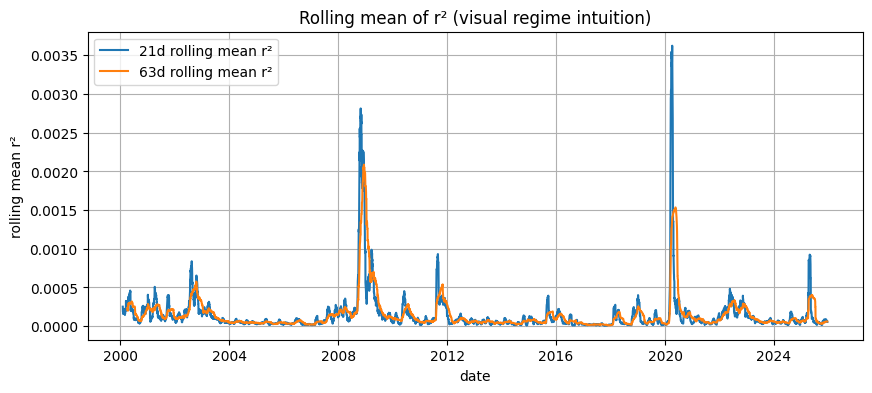

In [137]:
# Rolling mean of r² as a simple volatility proxy
win_short = 21
win_long = 63

roll_21 = data[cfg_ret.squared_return_col].rolling(win_short).mean()
roll_63 = data[cfg_ret.squared_return_col].rolling(win_long).mean()

fig, ax = plt.subplots()
ax.plot(data.index, roll_21.values, label=f"{win_short}d rolling mean r²")
ax.plot(data.index, roll_63.values, label=f"{win_long}d rolling mean r²")
ax.set_title("Rolling mean of r² (visual regime intuition)")
ax.set_xlabel("date")
ax.set_ylabel("rolling mean r²")
ax.legend()
plt.show(fig)
savefig(fig, FIG_DIR / "rolling_mean_r2_21_63.png")


### Interpretation

**What the plot shows:**
- **Calm periods:** Low, stable rolling variance (e.g., 2003-2007, 2012-2019)
- **Turbulent periods:** Elevated, volatile rolling variance (e.g., 2008-2009, 2020, 2022)
- **Transitions:** Sharp regime shifts often coincide with market crises

**Why this matters for model comparison:**
- GARCH's mean-reverting structure may overpredict in calm periods (expects reversion to long-run average)
- Neural models may underpredict spikes due to MSE minimization bias
- A model that "wins" on aggregate RMSE may actually fail badly in one regime while excelling in another

Notebook 06 formalizes this intuition using diagnostic metrics like **spike response time** and **regime-transition error** to understand how models behave differently across these periods.

## Summary and Next Steps

This notebook established the empirical foundation for comparative model analysis:

**Theoretical framework:**
- Daily conditional variance $\sigma_t^2$ is a conditional expectation, not an observable quantity
- Squared daily returns $r_t^2$ serve as an unbiased but extremely noisy estimator
- Evaluation against $r_t^2$ introduces inherent noise; low $R^2$ (0.05-0.15) is structurally expected

**Empirical findings:**
- **Heavy tails:** Extreme spikes in $r_t^2$ create asymmetric challenges for MSE-based optimization
- **Volatility clustering:** Strong autocorrelation in $r_t^2$ aligns with GARCH's autoregressive structure but must be learned by neural models
- **Regime dynamics:** Visual inspection reveals alternating calm/turbulent periods, motivating regime-conditional analysis

**Implications for model comparison:**
- GARCH's structural alignment with persistence and mean-reversion may provide advantages
- Neural models require robust transformations (log-variance) to handle heavy tails
- Aggregate performance metrics (RMSE, MAE) may obscure regime-dependent strengths and weaknesses

---

**Next:** Notebook 01 defines market regimes using **only trailing information** (no look-ahead bias) and validates that these regimes are statistically meaningful and stable. This sets the stage for regime-conditional model evaluation in later notebooks.